In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import os
from datetime import datetime
import re
import sys
sys.path.append('../src/')

import fasttext
import matplotlib as plt
import numpy as np
np.set_printoptions(precision=3)
import pandas as pd
import seaborn as sns
sns.set_theme()

from data_processor import PostProcessor

In [4]:
BASE_DATA_PATH = "/data/ddmg/personalizedmentalhealth/reddit_project/data"

# Apply step (1) exclusion criteria and step (2) text preprocessing

In [5]:
subreddits = os.listdir(BASE_DATA_PATH)
subreddits

['Family',
 'investing',
 'relationships',
 'medical',
 'mentalhealth',
 'bitcoin',
 'AskDocs',
 'relationship_advice',
 'personalfinance']

In [15]:
# create processed dataframes (only need to run once)
df_list = []
text_df_list = []
for sr in subreddits:
    print("Processing Posts in Subreddit: {}".format(sr))
    data_dir = os.path.join(BASE_DATA_PATH, sr, "posts")
    data_path = os.path.join(data_dir, "all.csv")
    pp = PostProcessor(data_path)
    filtered_ids = pp.filter(data_dir)
    df_list.append(pp.data_df)
    text_df = pp.preprocess_text(data_dir, filtered_ids)
    text_df_list.append(text_df)
    print()

Processing Posts in Subreddit: Family
Total dataset size: 31586
18921 posts=59.903121636167924% excluded because were deleted or removed
968 additional posts=7.643110935649427% excluded because no author
119 additional posts=1.0173548773189707% excluded because are links to articles
Final post 11578, which is 36.65548027607168% of original posts
starting processing of post text
initial dataset size is 11578
322 posts=2.781136638452237% removed because have URL ratio > 0.04
24 posts=0.21321961620469082% removed because contain table

Processing Posts in Subreddit: investing
Total dataset size: 162469
83415 posts=51.342102185647725% excluded because were deleted or removed
6298 additional posts=7.966706302021403% excluded because no author
9 additional posts=0.012370113805047007% excluded because are links to articles
Final post 72747, which is 44.77592648443703% of original posts
starting processing of post text
initial dataset size is 72747
5499 posts=7.5590746010144745% removed becaus

In [8]:
# load processed dataframes
df_list = []
text_df_list = []
for sr in subreddits:
    data_dir = os.path.join(BASE_DATA_PATH, sr, "posts")
    data_path = os.path.join(data_dir, "all.csv")
    data_df = pd.read_csv(data_path, low_memory=False)
    data_df.drop(columns="Unnamed: 0", inplace=True)
    filtered_id_path = os.path.join(data_dir, "1_filtered_ids.npy")
    filtered_ids = np.load(filtered_id_path, allow_pickle=True)
    data_df = data_df[data_df["id"].isin(filtered_ids)]
    df_list.append(data_df)
    text_path = os.path.join(data_dir, "2_processed_text.csv")
    text_df = pd.read_csv(text_path)
    text_df.drop(columns="Unnamed: 0", inplace=True)
    text_df_list.append(text_df)

In [9]:
main_df = pd.concat(df_list)
main_df.head(5)

,_reddit,approved_at_utc,subreddit,selftext,user_reports,saved,mod_reason_title,gilded,clicked,title,...,post_hint,preview,url_overridden_by_dest,crosspost_parent_list,crosspost_parent,media_metadata,link_flair_template_id,is_gallery,gallery_data,poll_data
3,<praw.reddit.Reddit object at 0x7f7e0d9601f0>,NaN,family,This is weird but I wondered if I could have s...,[],False,NaN,0,False,My Mum is acting really weird.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,<praw.reddit.Reddit object at 0x7f7e0d9601f0>,NaN,family,"Hi Everyone! I'm Jay 13 years old, I have a pr...",[],False,NaN,0,False,Awkward Situations w/ My Dad?,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,<praw.reddit.Reddit object at 0x7f7e0d9601f0>,NaN,family,"So, yesterday I was helping my mother with her...",[],False,NaN,0,False,Just found out my father isn't my father (afte...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,<praw.reddit.Reddit object at 0x7f7e0d9601f0>,NaN,family,"A public letter to my mother, Bonnie (aka Ambe...",[],False,NaN,0,False,Our mother left her family,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,<praw.reddit.Reddit object at 0x7f7e0d9601f0>,NaN,family,So my sister has 2 kids and is pregnant with a...,[],False,NaN,0,False,"Sister's shit of a ""man""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
text_df = pd.concat(text_df_list)
text_df.head(5)

,id,text
0,2rrm7n,My Mum is acting really weird. This is weird b...
1,2rgc78,Awkward Situations w/ My Dad? Hi Everyone! I'm...
2,2rdr14,Just found out my father isn't my father (afte...
3,2rbrfq,Our mother left her family A public letter to ...
4,2r6afm,"Sister's shit of a ""man"" So my sister has 2 ki..."


# Examine language detection step

In [11]:
model_path = "/data/ddmg/personalizedmentalhealth/reddit_project/tools/lid.176.bin"
lang_id_model = fasttext.load_model(model_path)

In [12]:
# need remove newlines before applying
text_df["new_text"] = text_df["text"].apply(lambda x: re.sub(r'\n+', ' ', x))

In [13]:
# get preds
texts = list(text_df["new_text"])
lang_preds = lang_id_model.predict(texts)

In [14]:
lang_preds[0][:5]

[['__label__en'],
 ['__label__en'],
 ['__label__en'],
 ['__label__en'],
 ['__label__en']]

In [15]:
lang_preds[1][:5]

[array([0.995], dtype=float32),
 array([0.989], dtype=float32),
 array([0.995], dtype=float32),
 array([0.982], dtype=float32),
 array([0.981], dtype=float32)]

In [16]:
text_df["lang"] = [x[0] for x in lang_preds[0]]

In [17]:
text_df["lang_conf"] = [x[0] for x in lang_preds[1]]

In [18]:
text_df.head(5)

,id,text,new_text,lang,lang_conf
0,2rrm7n,My Mum is acting really weird. This is weird b...,My Mum is acting really weird. This is weird b...,__label__en,0.995103
1,2rgc78,Awkward Situations w/ My Dad? Hi Everyone! I'm...,Awkward Situations w/ My Dad? Hi Everyone! I'm...,__label__en,0.988538
2,2rdr14,Just found out my father isn't my father (afte...,Just found out my father isn't my father (afte...,__label__en,0.994973
3,2rbrfq,Our mother left her family A public letter to ...,Our mother left her family A public letter to ...,__label__en,0.982227
4,2r6afm,"Sister's shit of a ""man"" So my sister has 2 ki...","Sister's shit of a ""man"" So my sister has 2 ki...",__label__en,0.980811


<AxesSubplot:xlabel='lang', ylabel='Count'>

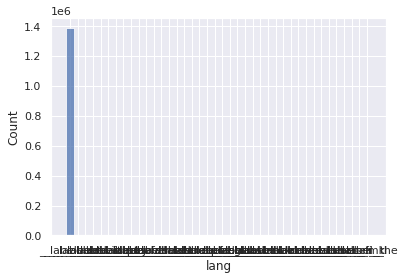

In [19]:
# get stats on how many are english vs not
sns.histplot(data=text_df, x="lang")

<AxesSubplot:xlabel='lang', ylabel='Count'>

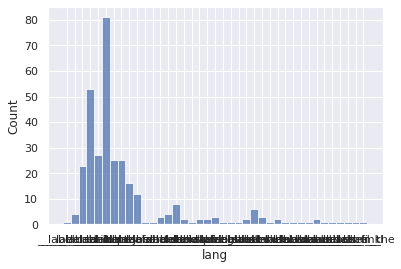

In [20]:
ne_df = text_df[text_df["lang"] != "__label__en"]
sns.histplot(data=ne_df, x="lang")

In [21]:
print("{}/{} posts are non-English={}%".format(len(ne_df), len(text_df), len(ne_df)*100/len(text_df)))

323/1387397 posts are non-English=0.02328100752704525%


In [22]:
eng_df = text_df[text_df["lang"] == "__label__en"]

In [23]:
len(eng_df)

1387074

<AxesSubplot:xlabel='lang_conf', ylabel='Count'>

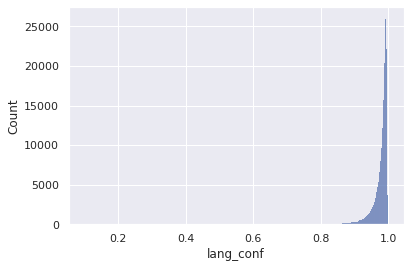

In [24]:
# look at confidence scores + posts with lowest confidence
sns.histplot(data=eng_df, x="lang_conf")

<AxesSubplot:xlabel='lang_conf', ylabel='Count'>

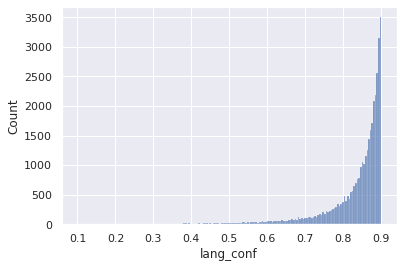

In [26]:
sns.histplot(data=eng_df[eng_df["lang_conf"] < .9], x="lang_conf")

In [27]:
lc_df = eng_df[eng_df["lang_conf"] < .5]

In [28]:
lc_df

,id,text,new_text,lang,lang_conf
34,31ivae,When The Sh*t Hits The Fan,When The Sh*t Hits The Fan,__label__en,0.301578
2747,9zulax,500 subscriber // Thanksgiving 2018 // Black F...,500 subscriber // Thanksgiving 2018 // Black F...,__label__en,0.210826
2976,a7jg01,क्या आप जानते है की लाइफ पार्टनर से झगड़ना भी ज...,क्या आप जानते है की लाइफ पार्टनर से झगड़ना भी ज...,__label__en,0.488544
3166,ahwlva,Sunny Day,Sunny Day,__label__en,0.332599
4081,c2lx8q,Foster Care,Foster Care,__label__en,0.430619
...,...,...,...,...,...
380142,hlnjzd,A Man In Love With You Can't Stay A Day withou...,A Man In Love With You Can't Stay A Day withou...,__label__en,0.232216
438628,im2dpf,My Girl friend IM 40 AND MY GIRLFRIEND IS A CO...,My Girl friend IM 40 AND MY GIRLFRIEND IS A CO...,__label__en,0.304470
443460,ivwdxn,I CANT FUCKING STAND MY STEP-FATHER NOT HELPIN...,I CANT FUCKING STAND MY STEP-FATHER NOT HELPIN...,__label__en,0.435185
455973,iyt154,LOVE SOMEONE HEY I LIKE A BOY...WHO WAS MY STU...,LOVE SOMEONE HEY I LIKE A BOY...WHO WAS MY STU...,__label__en,0.482924


In [61]:
# low confidence appear to be mainly posts with only a few words --> look at applying threshold first
eng_df["word_count"] = eng_df["text"].apply(lambda x: len(x.split(" ")))

<ipython-input-61-b10dd16aec90>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eng_df["word_count"] = eng_df["text"].apply(lambda x: len(x.split(" ")))


In [62]:
eng_df.head(5)

,id,text,new_text,lang,lang_conf,word_count
0,2rrm7n,My Mum is acting really weird. This is weird b...,My Mum is acting really weird. This is weird b...,__label__en,0.995103,119
1,2rgc78,Awkward Situations w/ My Dad? Hi Everyone! I'm...,Awkward Situations w/ My Dad? Hi Everyone! I'm...,__label__en,0.988538,302
2,2rdr14,Just found out my father isn't my father (afte...,Just found out my father isn't my father (afte...,__label__en,0.994973,600
3,2rbrfq,Our mother left her family A public letter to ...,Our mother left her family A public letter to ...,__label__en,0.982227,2316
4,2r6afm,"Sister's shit of a ""man"" So my sister has 2 ki...","Sister's shit of a ""man"" So my sister has 2 ki...",__label__en,0.980811,367


<AxesSubplot:xlabel='word_count', ylabel='Count'>

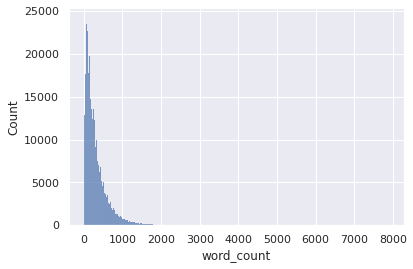

In [63]:
sns.histplot(data=eng_df, x="word_count")

<AxesSubplot:xlabel='word_count', ylabel='Count'>

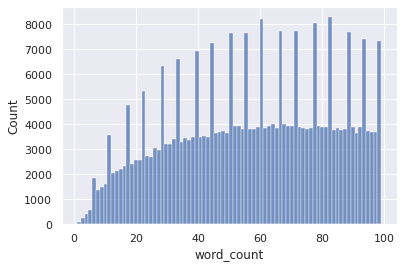

In [64]:
sns.histplot(data=eng_df[eng_df["word_count"] < 100], x="word_count")

<AxesSubplot:xlabel='word_count', ylabel='Count'>

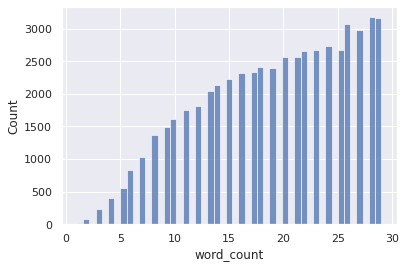

In [65]:
sns.histplot(data=eng_df[eng_df["word_count"] < 30], x="word_count")

In [66]:
lc_df = eng_df[eng_df["word_count"] < 20]

In [67]:
print("{}/{} posts have less than 20 words={}%".format(len(lc_df), len(eng_df), len(lc_df)*100/len(eng_df)))

27061/1387074 posts have less than 20 words=1.950941334060043%


In [68]:
lc_df = eng_df[eng_df["word_count"] < 15]
print("{}/{} posts have less than 15 words={}%".format(len(lc_df), len(eng_df), len(lc_df)*100/len(eng_df)))

15357/1387074 posts have less than 15 words=1.1071507360097588%


In [69]:
lc_df = eng_df[eng_df["word_count"] < 10]
print("{}/{} posts have less than 10 words={}%".format(len(lc_df), len(eng_df), len(lc_df)*100/len(eng_df)))

6005/1387074 posts have less than 10 words=0.43292571268728275%


In [70]:
lc_df = eng_df[eng_df["word_count"] < 5]
print("{}/{} posts have less than 5 words={}%".format(len(lc_df), len(eng_df), len(lc_df)*100/len(eng_df)))

732/1387074 posts have less than 5 words=0.05277295948161381%


In [71]:
new_df = eng_df[eng_df["word_count"] >= 10]

<AxesSubplot:xlabel='lang_conf', ylabel='Count'>

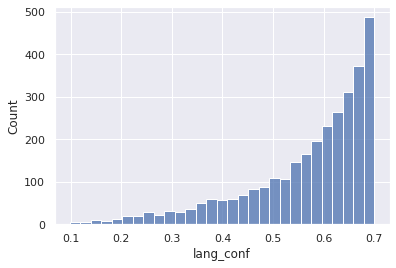

In [72]:
# now re-examine lang conf score distribution
sns.histplot(data=eng_df[eng_df["lang_conf"] < .7], x="lang_conf")

<AxesSubplot:xlabel='lang_conf', ylabel='Count'>

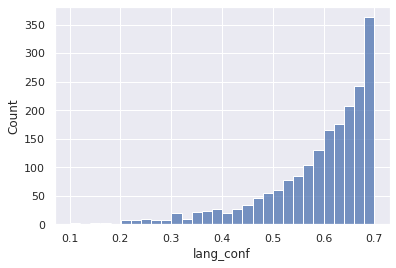

In [73]:
sns.histplot(data=new_df[new_df["lang_conf"] < .7], x="lang_conf")

In [74]:
lc_df = new_df[new_df["lang_conf"] < .4]
len(lc_df)

148

In [75]:
lc_df

,id,text,new_text,lang,lang_conf,word_count
9939,j29ufi,SURVIVING DYSFUNCTION **THERE ARE PLENTY OF TH...,SURVIVING DYSFUNCTION **THERE ARE PLENTY OF TH...,__label__en,0.363719,76
9082,4bwskp,How Do You Know When a Stock Hit a Bottom?,How Do You Know When a Stock Hit a Bottom?,__label__en,0.354635,10
10501,4kzgn7,Laugh the Economy Better [~~Jesus~~ Trump](htt...,Laugh the Economy Better [~~Jesus~~ Trump](htt...,__label__en,0.343657,55
22631,6yp250,$IGC PENNY STOCK ? Any thoughts on $IGC ??,$IGC PENNY STOCK ? Any thoughts on $IGC ??,__label__en,0.301780,10
23573,74p997,1 Google stock or 6 Facebook? 1 Google stock o...,1 Google stock or 6 Facebook? 1 Google stock o...,__label__en,0.360664,12
...,...,...,...,...,...,...
274100,eln08m,Is it okay for a guy who’s 28 or 29 to date a ...,Is it okay for a guy who’s 28 or 29 to date a ...,__label__en,0.399648,32
357949,gt9uqt,Your Friendship Your **Friendship**\n\nIs Like...,Your Friendship Your **Friendship** Is Like **...,__label__en,0.373242,19
380142,hlnjzd,A Man In Love With You Can't Stay A Day withou...,A Man In Love With You Can't Stay A Day withou...,__label__en,0.232216,136
438628,im2dpf,My Girl friend IM 40 AND MY GIRLFRIEND IS A CO...,My Girl friend IM 40 AND MY GIRLFRIEND IS A CO...,__label__en,0.304470,44


In [76]:
list(lc_df.head(5)["text"])

['SURVIVING DYSFUNCTION **THERE ARE PLENTY OF THINGS TO BE SAID ABOUT FAMILY WE NEVER KNOW WHAT FAMILY WE AARE GOING TO BE BORN INTO BUT NEVERTHELESS WE LOVE THEM ANYWAY NO MATTER HOW CORKY WEIRD LOUD CRAZY OR DYSFUNCTIONAL THEY ARE WE FIGHT TO STAY TOGETHER AND WE LOVE THEM TO NO END I AM A FIRM BELIEVER IN THIS NO ONES FAMILY IS PERFECT HELL THERES NO PERFECT BUT WE LOVE ALL THERE IMPERFECTIONS PERFECTLY**',
 'How Do You Know When a Stock Hit a Bottom?',
 'Laugh the Economy Better [~~Jesus~~ Trump](http://www.cnbc.com) gonna save us\n\nIts Super man. . . .no SpiderMan . . . Alan GreenSPan . . .huh?  Bernanke . . .nuh? . . .YELLEN!!!! . . .\n\nHory Shlit itsa   **Tlump** . . . .now all those Tleasulies gonna get sclewed fol good\n\n[Beware the +ve news cycle](http://www.cnbc.com)',
 '$IGC PENNY STOCK ? Any thoughts on $IGC ?? ',
 '1 Google stock or 6 Facebook? 1 Google stock or 6 Facebook?']

In [83]:
lc_df = new_df[new_df["lang_conf"] < .9]
print("{}/{} posts have less than .4 lang conf={}%".format(len(lc_df), len(eng_df), len(lc_df)*100/len(new_df)))

34228/1387074 posts have less than .4 lang conf=2.4783700162700053%


In [79]:
mc_df = new_df[(new_df["lang_conf"] < .8) & (new_df["lang_conf"] > .7)]

In [81]:
list(mc_df.head(5)["text"])

['Mind Quotes! The best cure of lonelyness is to get bond w/ your family ;-).\n\n\n#FirstTimer',
 'FREE STOYTIME EVENT Hear their side of the story with the Disney Villians Ursella, Cruella Devil, Evil Queen , and Maleficent FREE STOYTIME EVENT\nHear their side of the story with the Disney Villians\nUrsella, Cruella Devil, Evil Queen , and Maleficent  \nOctober 29, 2016 10:00 a.m.-12:00 p.m.\n6531 Annie Oakley Dr.\nHenderson, NV 89014\n702-405-7323\nhttp://www.glvacademy.com\n',
 'Do your kids fight too much? Do your kids fight too much?',
 'kinder-garden When do you prefer to give a kid to the kinder-garden?',
 "Family I Just Want To Shout-Out, \nThat I'm Not Fine, I'm Broken \nBut In The End Who Even Cares!!??"]